In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import collections
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Predicting Loan Eligibility with Machine Learning: An Analysis of Customer Data

**The goal** of this project is to use machine learning to automate the process of determining loan eligibility based on customer information collected through online application forms. The dataset contains details pertaining to the customer's demographic and socioeconomic attributes. 

**The aim** is to predict whether a loan will be approved or not, based on the provided customer information. 

The dataset, which includes variables such as Loan_ID, Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, and Loan_Status, can be found [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing).

**Process steps:**
1. Hypothesis Generation 
2. Data Cleaning
3. Exploratory Data Analysis  
4. Feature Engineering 
5. Model Building 


## 1. Hypothesis Generation

The initial phase of data analysis involves generating a hypothesis, which requires a clear understanding of the problem and the development of a relevant hypothesis that could positively impact the outcome. 
It is important to create this hypothesis prior to deeply examining the data, so that we can create a list of various analyses that may be performed once data is available.

Brief research on factors involved in determining the approval of loans yields to the following key points:
- Lenders consider **credit scores and reports** as they indicate how well individuals manage borrowed money and a poor credit history raises the risk of default. [Source](https://www.fool.com/the-ascent/personal-loans/articles/7-factors-lenders-look-considering-your-loan-application/)
- To ensure that borrowers can repay their loans, lenders assess their **income level and stability**, with higher income requirements for larger loans. In addition, steady employment is necessary, making it more difficult for self-employed individuals or those who only work part of the year to obtain a loan. [Source](https://www.fool.com/the-ascent/personal-loans/articles/7-factors-lenders-look-considering-your-loan-application/)
- Lenders assess a borrower's ability to make payments on current and new debt by calculating their **Debt-to-Income (DTI) ratio**, which is the percentage of their monthly gross income that goes towards debt service.[Source](https://www.forbes.com/advisor/personal-loans/personal-loan-requirements/)
- When applying for a secured personal loan, lenders typically require **collateral**, such as assets related to the loan's purpose or other valuable items like investments or collectibles, which they can seize in case of default or missed payments to recover the remaining loan amount. [Source](https://www.forbes.com/advisor/personal-loans/personal-loan-requirements/)
- Lenders evaluate loan applications by taking into account **economic conditions**, industry trends, and upcoming legislation that affect the borrower's business. [Source](https://www.bankofamerica.com/smallbusiness/resources/post/factors-that-impact-loan-decisions-and-how-to-increase-your-approval-odds/)


In [2]:
# Examine the data provided on loan candidates.
loan_applicant_df =  pd.read_csv('../data/data.csv')
loan_applicant_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Based on prior research on the domain and the dataset's attributes, several hypothesis for predicting loan approval for applicants:
- High income relative to loan
- Presence of coapplicant (with relatively high income)
- Married
- Low number of dependents 
- Graduate
- Not self-employed
- Urban/semi-urban property
- Credit history present 

It may be worth noting that the dataset *does not specify* the type of loan that's requested for, such as personal,  mortgage, home-equity, etc. Other possiblity important information that's missing includes a person's existing debts and assets, and indication of whether the income is net or gross. 
These attributes may affect loan approval/disapproval, and without it, our predictions may not be as accurate as they could otherwise be. 

## 2. Data Cleaning 

In [3]:
loan_applicant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


I am missing data for Gender, Married, Dependents, SelfEmployed, CreditHistory, LoanAmount and LoanAmountTerm. I can probably impute values for some of the missing data later.
There are more categorical than numerical features. 

In [4]:
nan_counts = loan_applicant_df.isna().sum()
print(nan_counts)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [5]:
loan_applicant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
# Strip spaces at the beginning and end of all strings in the dataframe
loan_applicant_df = loan_applicant_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [7]:
# Change data types, reorder categorical columns to the beginning, edit column names
loan_applicant_df['ApplicantIncome'] = loan_applicant_df['ApplicantIncome'].astype('float64')
loan_applicant_df = loan_applicant_df[['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status'] + list(loan_applicant_df.columns.difference(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']))]
loan_applicant_df = loan_applicant_df.rename(columns=lambda x: x.replace('_', ''))

In [8]:
# LoanID is the primary key, so check for duplicates
loan_applicant_df['LoanID'].duplicated().sum()

0

After creating a sub-dataframe of applicants with the same income, it doesn't seem like there are instances where the same person applied for multiple loans, at least at first glance. This means I won't be able to fill in missing data demographic/socioeconomical data based on another application by the same person.

In [9]:
# Check if the same person applied for multiple loans
duplicates = loan_applicant_df[loan_applicant_df.duplicated(['ApplicantIncome'], keep=False)]
num_duplicates = duplicates.shape[0]
print('Number of repeated ApplicantIncome:', num_duplicates)
grouped_duplicates = duplicates.groupby('ApplicantIncome')
duplicates.sort_values(by='ApplicantIncome').shape
duplicates.sort_values(by='ApplicantIncome').head(30)

Number of repeated ApplicantIncome: 169


,LoanID,Gender,Married,Dependents,Education,SelfEmployed,CreditHistory,PropertyArea,LoanStatus,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm
530,LP002717,Male,Yes,0,Graduate,No,NaN,Rural,Y,1025.0,5500.0,216.0,360.0
418,LP002345,Male,Yes,0,Graduate,No,1.0,Rural,Y,1025.0,2773.0,112.0,360.0
300,LP001964,Male,Yes,0,Not Graduate,No,0.0,Urban,N,1800.0,2934.0,93.0,360.0
41,LP001120,Male,No,0,Graduate,No,1.0,Urban,Y,1800.0,1213.0,47.0,360.0
170,LP001581,Male,Yes,0,Not Graduate,NaN,1.0,Rural,Y,1820.0,1769.0,95.0,360.0
422,LP002361,Male,Yes,0,Graduate,No,1.0,Urban,Y,1820.0,1719.0,100.0,360.0
485,LP002544,Male,Yes,1,Not Graduate,No,1.0,Rural,Y,1958.0,2436.0,131.0,360.0
451,LP002447,Male,Yes,2,Not Graduate,No,NaN,Urban,Y,1958.0,1456.0,60.0,300.0
131,LP001473,Male,No,0,Graduate,No,1.0,Urban,Y,2014.0,1929.0,74.0,360.0
299,LP001963,Male,Yes,1,Graduate,No,1.0,Urban,N,2014.0,2925.0,113.0,360.0


In [10]:
dependents_unique = loan_applicant_df['Dependents'].unique()
self_employed_unique = loan_applicant_df['SelfEmployed'].unique()
credit_history_unique = loan_applicant_df['CreditHistory'].unique()

print(f"Unique values for Dependents: {dependents_unique}")
print(f"Unique values for Self Employed: {self_employed_unique}")
print(f"Unique values for Credit History: {credit_history_unique}")


Unique values for Dependents: ['0' '1' '2' '3+' nan]
Unique values for Self Employed: ['No' 'Yes' nan]
Unique values for Credit History: [ 1.  0. nan]


In [11]:
# Count the number of occurrences of each unique value in the 'Dependents' column
dependents_counts = loan_applicant_df['Dependents'].value_counts(dropna=False)
print(dependents_counts)

# Count the number of occurrences of each unique value in the 'Self_Employed' column
self_employed_counts = loan_applicant_df['SelfEmployed'].value_counts(dropna=False)
print(self_employed_counts)

# Count the number of occurrences of each unique value in the 'Credit_History' column
credit_history_counts = loan_applicant_df['CreditHistory'].value_counts(dropna=False)
print(credit_history_counts)


0      345
1      102
2      101
3+      51
NaN     15
Name: Dependents, dtype: int64
No     500
Yes     82
NaN     32
Name: SelfEmployed, dtype: int64
1.0    475
0.0     89
NaN     50
Name: CreditHistory, dtype: int64


### The most common value in the 'Dependents' column is '0', while the most common value in the 'Self_Employed' column is 'No', and the most common value in the 'Credit_History' column is '1'. Therefore, I will use these modes to fill in the missing values in these respective columns.

In [12]:
# Set missing data for Dependents and SelfEmployed Unknown. I don't want to delete rows with missing data for those too early, because I might not end up using those columns for the model
# Set missing data for CreditHistory to Uknown for now
loan_applicant_df['Dependents'] = loan_applicant_df['Dependents'].fillna('0')
loan_applicant_df['SelfEmployed'] = loan_applicant_df['SelfEmployed'].fillna('No')
loan_applicant_df['CreditHistory'] = loan_applicant_df['CreditHistory'].fillna('1')
nan_counts = loan_applicant_df.isna().sum()
print(nan_counts)

LoanID                0
Gender               13
Married               3
Dependents            0
Education             0
SelfEmployed          0
CreditHistory         0
PropertyArea          0
LoanStatus            0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
LoanAmountTerm       14
dtype: int64


In [13]:
loan_applicant_df.head()

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,CreditHistory,PropertyArea,LoanStatus,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm
0,LP001002,Male,No,0,Graduate,No,1.0,Urban,Y,5849.0,0.0,NaN,360.0
1,LP001003,Male,Yes,1,Graduate,No,1.0,Rural,N,4583.0,1508.0,128.0,360.0
2,LP001005,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,3000.0,0.0,66.0,360.0
3,LP001006,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,2583.0,2358.0,120.0,360.0
4,LP001008,Male,No,0,Graduate,No,1.0,Urban,Y,6000.0,0.0,141.0,360.0


In [14]:
# Missing data on Gender may be caused by various reasons, including actually missing the data, or perhaps the person is non-binary
# Convert NaNs for Gender to Other to represent those cases
loan_applicant_df['Gender'] = loan_applicant_df['Gender'].fillna('Unknown')

In [15]:
# Missing data on Marriage may be caused by various reasons, including actually missing the data, or perhaps the person is in a common-law relationship
# Convert NaNs for Marriage to Other to represent those cases
loan_applicant_df['Married'] = loan_applicant_df['Married'].fillna('Unknown')

In [16]:
# Replace 1.0 with 1 and 0.0 with 0 in the 'Credit_History' column
loan_applicant_df['CreditHistory'] = loan_applicant_df['CreditHistory'].replace({1.0: 1, 0.0: 0})
# Replace '1' with 1 in the 'CreditHistory' column
loan_applicant_df['CreditHistory'] = loan_applicant_df['CreditHistory'].replace('1', 1)

In [17]:
# Check if there is other missing info or odd info that's not in the form of NaNs
for column in ['Gender', 'Married', 'Dependents', 'Education', 'SelfEmployed', 'CreditHistory', 'PropertyArea', 'LoanStatus']:
    print(column, loan_applicant_df[column].unique())

Gender ['Male' 'Female' 'Unknown']
Married ['No' 'Yes' 'Unknown']
Dependents ['0' '1' '2' '3+']
Education ['Graduate' 'Not Graduate']
SelfEmployed ['No' 'Yes']
CreditHistory [1 0]
PropertyArea ['Urban' 'Rural' 'Semiurban']
LoanStatus ['Y' 'N']


In [18]:
# Replace '3+' with 3 in the 'Dependents' column
loan_applicant_df['Dependents'] = loan_applicant_df['Dependents'].replace('3+', 3)

# Convert all values in the 'Dependents' column to integers
loan_applicant_df['Dependents'] = loan_applicant_df['Dependents'].astype(int)

loan_applicant_df = loan_applicant_df.rename(columns={'Education': 'Graduate'})

# Convert 'Graduate' to 1 and 'Not Graduate' to 0 in the 'Education' column
loan_applicant_df['Graduate'] = loan_applicant_df['Graduate'].map({'Graduate': 1, 'Not Graduate': 0})

In [19]:
# Convert 'Yes' to 1 and 'No' to 0 in the 'SelfEmployed' column
loan_applicant_df['SelfEmployed'] = loan_applicant_df['SelfEmployed'].map({'Yes': 1, 'No': 0})

# Rename the 'LoanStatus' column to 'LoanApproval' and convert values to binary
loan_applicant_df = loan_applicant_df.rename(columns={'LoanStatus': 'LoanApproval'})
loan_applicant_df['LoanApproval'] = loan_applicant_df['LoanApproval'].map({'Y': 1, 'N': 0})

In [20]:
# Check if there is other missing info or odd info that's not in the form of NaNs
for column in ['Gender', 'Married', 'Dependents', 'Graduate', 'SelfEmployed', 'CreditHistory', 'PropertyArea', 'LoanApproval']:
    print(column, loan_applicant_df[column].unique())

Gender ['Male' 'Female' 'Unknown']
Married ['No' 'Yes' 'Unknown']
Dependents [0 1 2 3]
Graduate [1 0]
SelfEmployed [0 1]
CreditHistory [1 0]
PropertyArea ['Urban' 'Rural' 'Semiurban']
LoanApproval [1 0]


In [21]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm']

for column in numerical_columns:
    col_range = loan_applicant_df[column].describe()[['min', 'max']]
    print(f"{column} range: {col_range['min']} - {col_range['max']}")


ApplicantIncome range: 150.0 - 81000.0
CoapplicantIncome range: 0.0 - 41667.0
LoanAmount range: 9.0 - 700.0
LoanAmountTerm range: 12.0 - 480.0


It's odd that there are entries where the ApplicantIncomeis 150, and LoanAmount is 9. 
However, looking at the distributions of Income and Loans, they are somewhat proportional in that, the mean income is 5403 and the mean loan is 146. 
I will add an extra 0 to ApplicantIncome and CoapplicantIncome. Since the units of LoanAmountTerm is most likely in months, I will add multiply the LoanAmount by 1000.

In [22]:
loan_applicant_df.describe()

,Dependents,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,592.000000,600.00000
mean,0.744300,0.781759,0.133550,0.855049,0.687296,5403.459283,1621.245798,146.412162,342.00000
std,1.009623,0.413389,0.340446,0.352339,0.463973,6109.041673,2926.248369,85.587325,65.12041
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.00000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,2877.500000,0.000000,100.000000,360.00000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,3812.500000,1188.500000,128.000000,360.00000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,5795.000000,2297.250000,168.000000,360.00000
max,3.000000,1.000000,1.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.00000


In [23]:
loan_applicant_df[['ApplicantIncome', 'CoapplicantIncome']] = loan_applicant_df[['ApplicantIncome', 'CoapplicantIncome']].multiply(10)
loan_applicant_df.describe()

,Dependents,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,592.000000,600.00000
mean,0.744300,0.781759,0.133550,0.855049,0.687296,54034.592834,16212.457980,146.412162,342.00000
std,1.009623,0.413389,0.340446,0.352339,0.463973,61090.416734,29262.483692,85.587325,65.12041
min,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,0.000000,9.000000,12.00000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,28775.000000,0.000000,100.000000,360.00000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,38125.000000,11885.000000,128.000000,360.00000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,57950.000000,22972.500000,168.000000,360.00000
max,3.000000,1.000000,1.000000,1.000000,1.000000,810000.000000,416670.000000,700.000000,480.00000


In [24]:
loan_applicant_df[['LoanAmount']] = loan_applicant_df[['LoanAmount']].multiply(1000)
loan_applicant_df.describe()

,Dependents,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,592.000000,600.00000
mean,0.744300,0.781759,0.133550,0.855049,0.687296,54034.592834,16212.457980,146412.162162,342.00000
std,1.009623,0.413389,0.340446,0.352339,0.463973,61090.416734,29262.483692,85587.325236,65.12041
min,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,0.000000,9000.000000,12.00000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,28775.000000,0.000000,100000.000000,360.00000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,38125.000000,11885.000000,128000.000000,360.00000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,57950.000000,22972.500000,168000.000000,360.00000
max,3.000000,1.000000,1.000000,1.000000,1.000000,810000.000000,416670.000000,700000.000000,480.00000


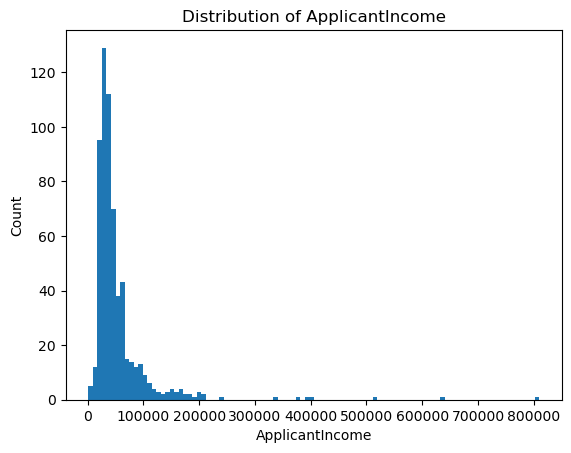

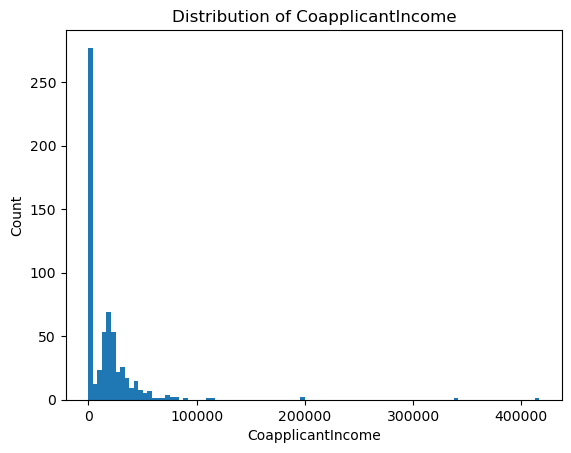

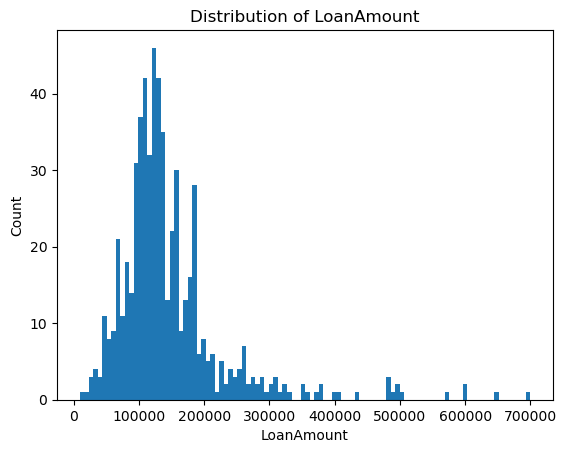

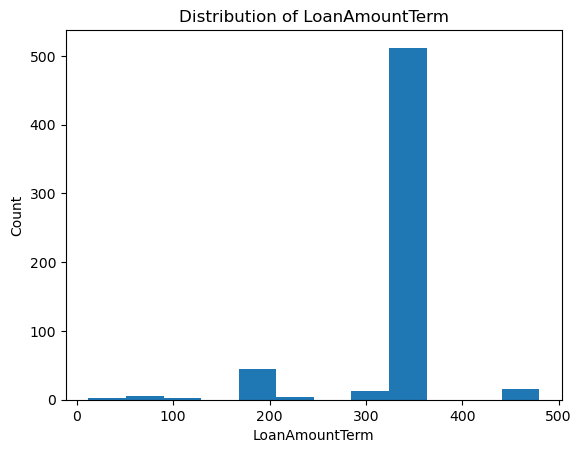

In [25]:
# Plot distribution of ApplicantIncome
plt.hist(loan_applicant_df['ApplicantIncome'], bins=100)
plt.title('Distribution of ApplicantIncome')
plt.xlabel('ApplicantIncome')
plt.ylabel('Count')
plt.show()

# Plot distribution of CoapplicantIncome
plt.hist(loan_applicant_df['CoapplicantIncome'], bins=100)
plt.title('Distribution of CoapplicantIncome')
plt.xlabel('CoapplicantIncome')
plt.ylabel('Count')
plt.show()

# Plot distribution of LoanAmount
plt.hist(loan_applicant_df['LoanAmount'], bins=100)
plt.title('Distribution of LoanAmount')
plt.xlabel('LoanAmount')
plt.ylabel('Count')
plt.show()

# Plot distribution of LoanAmountTerm
plt.hist(loan_applicant_df['LoanAmountTerm'], bins=12)
plt.title('Distribution of LoanAmountTerm')
plt.xlabel('LoanAmountTerm')
plt.ylabel('Count')
plt.show()

#### Delete outliers for ApplicantIncome, CoapplicantIncome, LoanAmount

In [26]:
# Select the columns to check for outliers
cols_to_check = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

# Calculate the quartiles for the selected columns
q1 = loan_applicant_df[cols_to_check].quantile(0.25)
q3 = loan_applicant_df[cols_to_check].quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define the upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Create a boolean mask to identify the rows with outliers
mask = (loan_applicant_df[cols_to_check] >= lower_bound) & (loan_applicant_df[cols_to_check] <= upper_bound)

# Filter the dataframe to remove the rows with outliers
loan_applicant_df = loan_applicant_df[mask.all(axis=1)]


In [27]:
loan_applicant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoanID             517 non-null    object 
 1   Gender             517 non-null    object 
 2   Married            517 non-null    object 
 3   Dependents         517 non-null    int64  
 4   Graduate           517 non-null    int64  
 5   SelfEmployed       517 non-null    int64  
 6   CreditHistory      517 non-null    int64  
 7   PropertyArea       517 non-null    object 
 8   LoanApproval       517 non-null    int64  
 9   ApplicantIncome    517 non-null    float64
 10  CoapplicantIncome  517 non-null    float64
 11  LoanAmount         517 non-null    float64
 12  LoanAmountTerm     503 non-null    float64
dtypes: float64(4), int64(5), object(4)
memory usage: 56.5+ KB


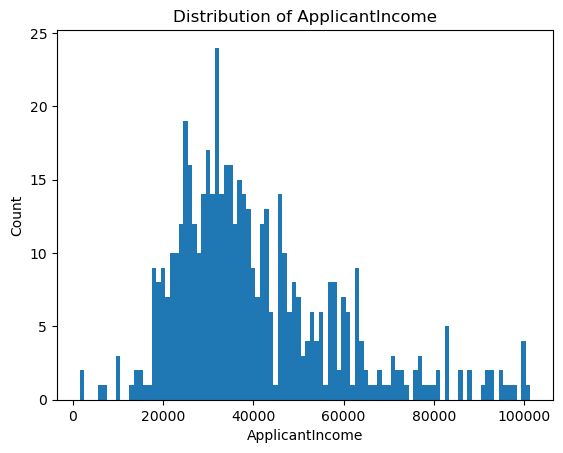

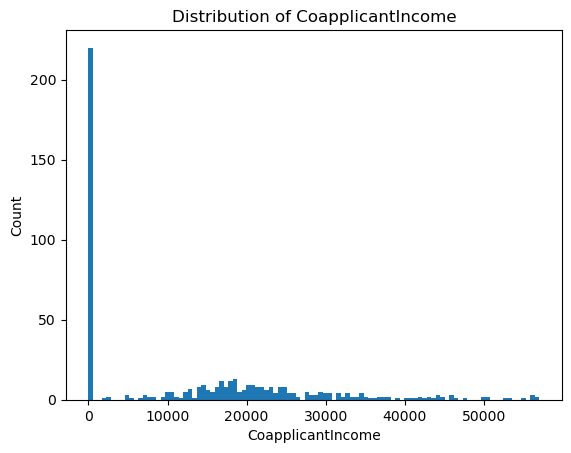

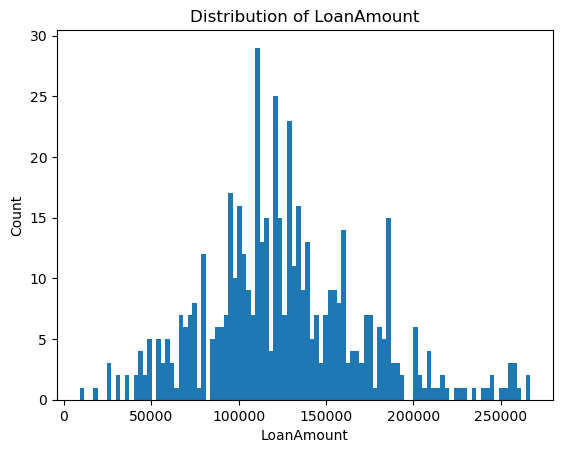

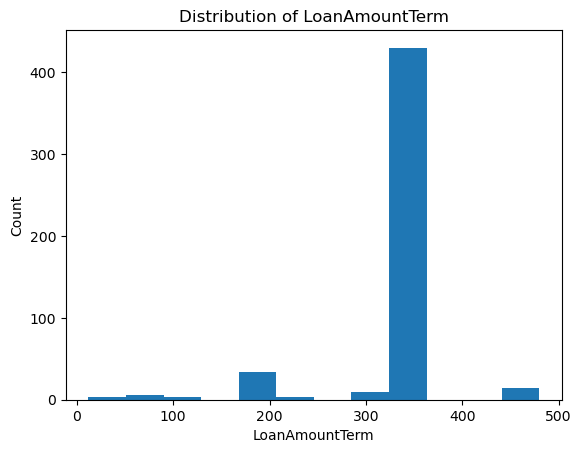

In [28]:
# Plot distribution of ApplicantIncome
plt.hist(loan_applicant_df['ApplicantIncome'], bins=100)
plt.title('Distribution of ApplicantIncome')
plt.xlabel('ApplicantIncome')
plt.ylabel('Count')
plt.show()

# Plot distribution of CoapplicantIncome
plt.hist(loan_applicant_df['CoapplicantIncome'], bins=100)
plt.title('Distribution of CoapplicantIncome')
plt.xlabel('CoapplicantIncome')
plt.ylabel('Count')
plt.show()

# Plot distribution of LoanAmount
plt.hist(loan_applicant_df['LoanAmount'], bins=100)
plt.title('Distribution of LoanAmount')
plt.xlabel('LoanAmount')
plt.ylabel('Count')
plt.show()

# Plot distribution of LoanAmountTerm
plt.hist(loan_applicant_df['LoanAmountTerm'], bins=12)
plt.title('Distribution of LoanAmountTerm')
plt.xlabel('LoanAmountTerm')
plt.ylabel('Count')
plt.show()

### Regression imputation for LoanAmountTerm 

In [29]:
regress_impute = loan_applicant_df.copy()
regress_impute[['Gender', 'Married', 'Dependents','PropertyArea']] = regress_impute[['Gender', 'Married', 'Dependents','PropertyArea']].astype(str)   

In [30]:
# Drop 'LoanID' column
regress_impute = regress_impute.drop('LoanID', axis=1)

In [31]:
regress_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             517 non-null    object 
 1   Married            517 non-null    object 
 2   Dependents         517 non-null    object 
 3   Graduate           517 non-null    int64  
 4   SelfEmployed       517 non-null    int64  
 5   CreditHistory      517 non-null    int64  
 6   PropertyArea       517 non-null    object 
 7   LoanApproval       517 non-null    int64  
 8   ApplicantIncome    517 non-null    float64
 9   CoapplicantIncome  517 non-null    float64
 10  LoanAmount         517 non-null    float64
 11  LoanAmountTerm     503 non-null    float64
dtypes: float64(4), int64(4), object(4)
memory usage: 52.5+ KB


In [32]:
# One-hot encode the specified columns
columns_to_encode = ['Gender', 'Married', 'Dependents','PropertyArea']
regress_impute_encoded = pd.get_dummies(regress_impute, columns=columns_to_encode)

In [33]:
regress_impute_encoded.columns

Index(['Graduate', 'SelfEmployed', 'CreditHistory', 'LoanApproval',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm',
       'Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Married_No',
       'Married_Unknown', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3', 'PropertyArea_Rural',
       'PropertyArea_Semiurban', 'PropertyArea_Urban'],
      dtype='object')

In [34]:
cols_to_check = ['LoanAmountTerm']
nans_per_column = regress_impute[cols_to_check].isna().sum()
print(nans_per_column)

LoanAmountTerm    14
dtype: int64


In [35]:
def un_min_max(scaled,unscaled):
    "Unscale min-max scaled data using separate unscaled data as a reference."
    return (scaled * (unscaled.max() - unscaled.min())) + unscaled.min()

In [36]:
# Select the columns to scale
cols_to_scale = ['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'LoanAmountTerm']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the selected columns
regress_impute_encoded[cols_to_scale] = scaler.fit_transform(regress_impute_encoded[cols_to_scale])

# Verify that the scaling has been applied
print(regress_impute_encoded[cols_to_scale].describe())

       ApplicantIncome  LoanAmount  CoapplicantIncome  LoanAmountTerm
count       517.000000  517.000000         517.000000      503.000000
mean          0.390875    0.456720           0.234487        0.706122
std           0.184226    0.178484           0.250580        0.141977
min           0.000000    0.000000           0.000000        0.000000
25%           0.262088    0.348837           0.000000        0.743590
50%           0.345180    0.437984           0.225750        0.743590
75%           0.475023    0.562016           0.387651        0.743590
max           1.000000    1.000000           1.000000        1.000000


In [37]:
# Split the dataset into two parts: one with the missing values and the other with the observed values
missing_data = regress_impute_encoded[regress_impute_encoded['LoanAmountTerm'].isna()]
observed_data = regress_impute_encoded[~regress_impute_encoded['LoanAmountTerm'].isna()]

# Define the dependent variable and the independent variables for the regression model
X = observed_data[['Graduate', 'SelfEmployed', 'CreditHistory', 'LoanApproval',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Married_No',
       'Married_Unknown', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3', 'PropertyArea_Rural',
       'PropertyArea_Semiurban', 'PropertyArea_Urban']]
y = observed_data['LoanAmountTerm']

# Fit a linear regression model using the non-missing dataset
regressor = LinearRegression()
regressor.fit(X, y)

# Use the fitted model to predict the missing values in the missing dataset
X_missing = missing_data[['Graduate', 'SelfEmployed', 'CreditHistory', 'LoanApproval',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Gender_Female', 'Gender_Male', 'Gender_Unknown', 'Married_No',
       'Married_Unknown', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3', 'PropertyArea_Rural',
       'PropertyArea_Semiurban', 'PropertyArea_Urban']]
y_pred = regressor.predict(X_missing)

# Replace the missing values with the predicted values
missing_data['LoanAmountTerm'] = y_pred
imputed_data = pd.concat([observed_data, missing_data])

/var/folders/rk/815pd2rj3l5gyxnkn8q_m5sc0000gn/T/ipykernel_1654/3419674778.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['LoanAmountTerm'] = y_pred


In [38]:
print(y_pred*(loan_applicant_df.LoanAmountTerm.max() - loan_applicant_df.LoanAmountTerm.min()) + loan_applicant_df.LoanAmountTerm.min())

[330.03067429 343.60718852 305.65542997 349.08600501 319.95378276
 335.77152541 359.7928087  347.694398   342.45497506 343.89971869
 288.18642725 356.75242042 342.19056631 288.49216192]


In [39]:
imputed_data.head()

,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,Gender_Female,Gender_Male,...,Married_No,Married_Unknown,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
1,1,0,1,0,0.443788,0.264515,0.461240,0.74359,0,1,...,0,0,1,0,1,0,0,1,0,0
2,1,1,1,1,0.285314,0.000000,0.220930,0.74359,0,1,...,0,0,1,1,0,0,0,0,0,1
3,0,0,1,1,0.243568,0.413612,0.430233,0.74359,0,1,...,0,0,1,1,0,0,0,0,0,1
4,1,0,1,1,0.585644,0.000000,0.511628,0.74359,0,1,...,1,0,0,1,0,0,0,0,0,1
5,1,1,1,1,0.527280,0.736011,1.000000,0.74359,0,1,...,0,0,1,0,0,1,0,0,0,1


In [40]:
# Specify the columns to unscale
cols_to_unscale = ['ApplicantIncome', 'LoanAmount', 'CoapplicantIncome', 'LoanAmountTerm']

# Loop over each column to unscale
for col in cols_to_unscale:
    # Unscale the column using the un_min_max() function
    imputed_data[col] = un_min_max(imputed_data[col], regress_impute[col])
    
# Print the head of the unscaled data
imputed_data.describe()

,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,Gender_Female,Gender_Male,...,Married_No,Married_Unknown,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,...,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,0.760155,0.114120,0.856867,0.702128,40544.506770,13368.083559,126833.655706,342.192588,0.187621,0.794971,...,0.348162,0.003868,0.647969,0.601547,0.154739,0.170213,0.073501,0.299807,0.388781,0.311412
std,0.427402,0.318265,0.350548,0.457766,18402.349856,14285.540810,46048.880635,65.662458,0.390787,0.404114,...,0.476849,0.062137,0.478066,0.490054,0.362006,0.376184,0.261210,0.458617,0.487946,0.463519
min,0.000000,0.000000,0.000000,0.000000,1500.000000,0.000000,9000.000000,12.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,27680.000000,0.000000,99000.000000,360.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,35980.000000,12870.000000,122000.000000,360.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,48950.000000,22100.000000,154000.000000,360.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,101390.000000,57010.000000,267000.000000,480.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# Select the columns to round
cols_to_round = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm']

# Round the values in the selected columns
imputed_data[cols_to_round] = imputed_data[cols_to_round].round(decimals=2)

# Print the head of the unscaled data
imputed_data.head()


,Graduate,SelfEmployed,CreditHistory,LoanApproval,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,Gender_Female,Gender_Male,...,Married_No,Married_Unknown,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
1,1,0,1,0,45830.0,15080.0,128000.0,360.0,0,1,...,0,0,1,0,1,0,0,1,0,0
2,1,1,1,1,30000.0,0.0,66000.0,360.0,0,1,...,0,0,1,1,0,0,0,0,0,1
3,0,0,1,1,25830.0,23580.0,120000.0,360.0,0,1,...,0,0,1,1,0,0,0,0,0,1
4,1,0,1,1,60000.0,0.0,141000.0,360.0,0,1,...,1,0,0,1,0,0,0,0,0,1
5,1,1,1,1,54170.0,41960.0,267000.0,360.0,0,1,...,0,0,1,0,0,1,0,0,0,1


In [42]:
cols_to_move = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'LoanAmountTerm']
new_order = cols_to_move + [col for col in imputed_data.columns if col not in cols_to_move]
df = imputed_data.reindex(columns=new_order)
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,Graduate,SelfEmployed,CreditHistory,LoanApproval,Gender_Female,Gender_Male,...,Married_No,Married_Unknown,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3,PropertyArea_Rural,PropertyArea_Semiurban,PropertyArea_Urban
1,45830.0,15080.0,128000.0,360.0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,1,0,0
2,30000.0,0.0,66000.0,360.0,1,1,1,1,0,1,...,0,0,1,1,0,0,0,0,0,1
3,25830.0,23580.0,120000.0,360.0,0,0,1,1,0,1,...,0,0,1,1,0,0,0,0,0,1
4,60000.0,0.0,141000.0,360.0,1,0,1,1,0,1,...,1,0,0,1,0,0,0,0,0,1
5,54170.0,41960.0,267000.0,360.0,1,1,1,1,0,1,...,0,0,1,0,0,1,0,0,0,1


In [45]:
unique_terms = loan_applicant_df['LoanAmountTerm'].unique()
print(unique_terms)


[360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]


In [46]:
unique_terms = df['LoanAmountTerm'].unique()
print(unique_terms)

[360.   120.   240.   180.    60.   300.   480.    36.    84.    12.
 330.03 343.61 305.66 349.09 319.95 335.77 359.79 347.69 342.45 343.9
 288.19 356.75 342.19 288.49]


In [47]:
# Set of possible values to round to
possible_terms = np.array([360, 120, 240, 180, 60, 300, 480, 36, 84, 12])

# Define a function to find the nearest value in the set
def find_nearest(term):
    idx = (np.abs(possible_terms - term)).argmin()
    return possible_terms[idx]

# Apply the function to round the 'LoanAmountTerm' column
df['LoanAmountTerm'] = df['LoanAmountTerm'].apply(lambda x: find_nearest(x))

In [48]:
unique_terms = df['LoanAmountTerm'].unique()
print(unique_terms)

[360 120 240 180  60 300 480  36  84  12]


In [49]:
df.to_csv('../data/data_preprocessed.csv', index=False)